# Introduction
Telecom operator Interconnect wants to reduce customer churn.  In this project, we will develop a machine learning model to predict which customers are planning to leave.  Interconnect can then offer promotional codes and special plan options to incentivize customers to stay.

## Services offered
Main services:
- Landline
- Internet (DSL, fiber optic)

Other services:
- Internet security (antivirus, malicious website blocker)
- Dedicated tech support
- Cloud file storage and data backup
- TV streaming and a movie directory

Clients can choose either monthly plan or 1- or 2-year contract.

# Preliminary data review
In this section, we will get a "feel" for the data and identify preprocessing requirements.

In [1]:
import importlib 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import tensorflow as tf
import warnings

from catboost import CatBoostClassifier
from copy import deepcopy
from functools import reduce
from scipy.stats import randint
from sklearn.dummy import DummyClassifier
from sklearn.experimental import enable_halving_search_cv, enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score, \
                            f1_score, auc, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, HalvingGridSearchCV, \
                                    StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample, shuffle

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

In [3]:
try:
    contract_df = pd.read_csv('/datasets/contract.csv')
    personal_df = pd.read_csv('/datasets/personal.csv')
    internet_df = pd.read_csv('/datasets/internet.csv')
    phone_df = pd.read_csv('/datasets/phone.csv')
except:
    contract_df = pd.read_csv('contract.csv')
    personal_df = pd.read_csv('personal.csv')
    internet_df = pd.read_csv('internet.csv')
    phone_df = pd.read_csv('phone.csv')

In [4]:
RANDOM_STATE = 54321
FIGSIZE = (8,6)
FINDING_HYPERPARAMETERS = False

## Contract

In [5]:
display(contract_df.info())
display(contract_df.sample(5, random_state=RANDOM_STATE))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5166,2252-JHJGE,2015-01-01,No,One year,No,Electronic check,104.00,6363.45
1187,8089-UZWLX,2014-03-01,No,Two year,No,Bank transfer (automatic),104.05,7413.55
3888,6086-ESGRL,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Credit card (automatic),80.15,80.15
5279,0394-YONDK,2014-04-01,No,Two year,No,Credit card (automatic),25.15,1790.15
5195,1676-MQAOA,2014-02-01,No,Two year,Yes,Bank transfer (automatic),75.10,5336.35


Check for inconsistent or duplicate values among the categorical columns:

In [6]:
display(contract_df['Type'].value_counts())
display(contract_df['PaperlessBilling'].value_counts())
display(contract_df['PaymentMethod'].value_counts())

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

## Personal

In [7]:
display(personal_df.info())
display(personal_df.sample(5, random_state=RANDOM_STATE))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
5166,2252-JHJGE,Male,0,No,No
1187,8089-UZWLX,Female,1,No,No
3888,6086-ESGRL,Female,0,No,No
5279,0394-YONDK,Male,0,Yes,Yes
5195,1676-MQAOA,Male,0,No,No


In [8]:
display(personal_df['gender'].value_counts())
display(personal_df['SeniorCitizen'].value_counts())
display(personal_df['Partner'].value_counts())
display(personal_df['Dependents'].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

No     3641
Yes    3402
Name: Partner, dtype: int64

No     4933
Yes    2110
Name: Dependents, dtype: int64

## Internet

In [9]:
display(internet_df.info())
display(internet_df.sample(5, random_state=RANDOM_STATE))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
811,3748-FVMZZ,DSL,No,No,No,Yes,No,Yes
540,0214-JHPFW,DSL,No,Yes,Yes,Yes,Yes,Yes
2183,4760-THGOT,Fiber optic,Yes,Yes,No,No,No,Yes
2019,9600-UDOPK,Fiber optic,No,No,No,No,Yes,Yes
1355,1702-CCFNJ,DSL,No,Yes,No,Yes,No,No


In [10]:
for c in internet_df.columns[1:]:
    display(internet_df.value_counts(c))

InternetService
Fiber optic    3096
DSL            2421
dtype: int64

OnlineSecurity
No     3498
Yes    2019
dtype: int64

OnlineBackup
No     3088
Yes    2429
dtype: int64

DeviceProtection
No     3095
Yes    2422
dtype: int64

TechSupport
No     3473
Yes    2044
dtype: int64

StreamingTV
No     2810
Yes    2707
dtype: int64

StreamingMovies
No     2785
Yes    2732
dtype: int64

## Phone

In [11]:
display(phone_df.info())
display(phone_df.sample(5, random_state=RANDOM_STATE))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
5497,3055-OYMSE,No
4201,0311-QYWSS,No
475,8067-NIOYM,No
4640,5371-VYLSX,Yes
740,0036-IHMOT,No


## Conclusion (prelim data review)
General observations:
- Data is provided in 4 files:  `contract.csv`, `personal.csv`, `internet.csv`, and `phone.csv`.
- The files are linked by the `customerID` field.
- The `contract` and `personal` files each have 7,043 entries.
- The `internet` and `phone` files have fewer entries, suggesting possible missing data.  This is likely because some customers did not purchase internet or phone services.  As we combine the data into a single dataframe, we can capture which whether the customer has each service.

Observations for each file:
- `contract`
    - `BeginDate` should be converted to `datetime`.
    - `EndDate` can be used to create our target variable, i.e., whether or not the customer churned.  
    - `EndDate` can then be used to create a new feature indicating how long customer was/has been on the service.
    - `Type`, `PaperlessBilling`, and `PaymentMethod`:  These columns are all internally consistent (e.g., no duplicate values).
    - `TotalCharges` should be `float64`. It appears that there are empty strings for some rows.
- `personal`, `internet`, and `phone`:  This columns of these files are mostly binary indicators, and the values are internally consistent.
- `internet` shows a large number of internet services.  We can add the total number of internet services as a numeric feature.
- `phone` has a column that indicates whether the customer has multiple lines.  We could simplify this to 0 (for customers with no phone service), 1 for a single line, and 2 for multiple lines.

In the following section, we will address these preprocessing requirements and combine the data into a single dataframe for EDA and modeling.

# Preprocessing
In this section, we will handle the preprocessing requirements identified in the previous section and merge the datasets.

## Contract

Convert `BeginDate` to `datetime`:

In [12]:
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'])

Create target feature `Churned` from `EndDate`:

In [13]:
contract_df['Churned'] = contract_df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

Next, we will replace 'No' values in `EndDate` with today's date: February 1, 2020.

In [14]:
contract_df['EndDate'] = contract_df['EndDate'].apply(lambda x: x if x != 'No' else '2020-02-01')

Convert `EndDate` to `datetime`: 

In [15]:
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'])

Add a feature indicating how long patient was (or has been) on the service:

In [16]:
contract_df['ServiceDays'] = (contract_df['EndDate'] - contract_df['BeginDate']).dt.days

Convert `TotalCharges` to numeric:

In [17]:
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce')
contract_df['TotalCharges'].isna().sum()

11

There were just 11 non-numeric values.  We will convert them to 0.0.

In [18]:
contract_df['TotalCharges'] = contract_df['TotalCharges'].fillna(0.0)

Having captured the important information from `BeginDate` and `EndDate`, namely, whether the customer churned and how long customer was/has been on the service, we can now delete these columns:

In [19]:
contract_df.drop(columns=['BeginDate', 'EndDate'], inplace=True)

Review the results of preprocesing:

In [20]:
display(contract_df.info())
display(contract_df.sample(5, random_state=RANDOM_STATE))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   Churned           7043 non-null   int64  
 7   ServiceDays       7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


None

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churned,ServiceDays
5166,2252-JHJGE,One year,No,Electronic check,104.00,6363.45,0,1857
1187,8089-UZWLX,Two year,No,Bank transfer (automatic),104.05,7413.55,0,2163
3888,6086-ESGRL,Month-to-month,No,Credit card (automatic),80.15,80.15,1,30
5279,0394-YONDK,Two year,No,Credit card (automatic),25.15,1790.15,0,2132
5195,1676-MQAOA,Two year,Yes,Bank transfer (automatic),75.10,5336.35,0,2191


## Internet and Phone

Add the total number of internet services as a feature.  Later, we will set a value of zero for customers with no internet service.

In [21]:
def internet_service_count(row):
    count = 1 # This is for internet service itself.
    for service in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies']:
        if row[service] == 'Yes':
            count += 1
    return count

internet_df['InternetServiceCount'] = internet_df.apply(internet_service_count, axis=1)

Similarly, we will add a feature for 1 or more phone lines.  We will assume that 'MultipleLines' means 2.  Later, we will set a value of zero for customers with no phone service.

In [22]:
phone_df['PhoneLineCount'] = phone_df['MultipleLines'].apply(lambda x: 1 if x == 'No' else 2)

As we found above, not all customers have *both* internet and phone service.  In the next section, we will be combining our 4 dataframes together, but first we will add a new feature to indicate whether the customer has the service.

In [23]:
internet_df['HasInternet'] = 1
internet_df['HasPhone'] = 1

## Merge dataframes

We will combine our dataframes into a single dataframe for further analysis.  We will fill missing values for customers that don't have phone or internet service with 'NA'.

In [24]:
df = reduce(lambda left, right: pd.merge(left,
                                         right,
                                         on=['customerID'],
                                         how='outer'
                                        ), [contract_df, personal_df, internet_df, phone_df]).fillna(0)

Now that the dataframes have been merged, we no longer need `CustomerID`:

In [25]:
df.drop(columns=['customerID'], inplace=True)

Reorder the columns so that `Churned` is first, and so that the columns we added are close to related values (e.g., internet, phone).

In [26]:
df = df[['Churned',                                          # Target
         'Type', 'PaperlessBilling', 'PaymentMethod',        # Billing info
         'MonthlyCharges', 'TotalCharges',                   # Billing amounts
         'ServiceDays',                                      # Days with service
         'gender', 'SeniorCitizen', 'Partner', 'Dependents', # Personal info
         'HasInternet', 'InternetServiceCount',              # Internet
         'InternetService', 'OnlineSecurity', 'OnlineBackup', 
         'DeviceProtection', 'TechSupport', 'StreamingTV', 
         'StreamingMovies', 
         'HasPhone', 'PhoneLineCount', 'MultipleLines'       # Phone
        
        ]]

A couple of binary indicator values were marked 'Yes' or 'No'. Let's change these to 1's and 0's.

In [27]:
df.replace('No', 0, inplace=True)
df.replace('Yes', 1, inplace=True)

Similarly, we will change the `gender` field to a binary indicator.

In [28]:
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)

Since there are only two internet service types, we can also change this to a binary indicator.

In [29]:
df['InternetService'] = df['InternetService'].apply(lambda x: 1 if x == 'DSL' else 0)

Merging resulted in `float` type for several indicators.  Change these to `int`.

In [30]:
df['HasInternet'] = df['HasInternet'].astype(int)
df['HasPhone'] = df['HasPhone'].astype(int)
df['InternetServiceCount'] = df['InternetServiceCount'].astype(int)
df['PhoneLineCount'] = df['PhoneLineCount'].astype(int)

Merged dataframe:

In [31]:
display(df.info())
display(df.sample(5, random_state=RANDOM_STATE))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Churned               7043 non-null   int64  
 1   Type                  7043 non-null   object 
 2   PaperlessBilling      7043 non-null   int64  
 3   PaymentMethod         7043 non-null   object 
 4   MonthlyCharges        7043 non-null   float64
 5   TotalCharges          7043 non-null   float64
 6   ServiceDays           7043 non-null   int64  
 7   gender                7043 non-null   int64  
 8   SeniorCitizen         7043 non-null   int64  
 9   Partner               7043 non-null   int64  
 10  Dependents            7043 non-null   int64  
 11  HasInternet           7043 non-null   int64  
 12  InternetServiceCount  7043 non-null   int64  
 13  InternetService       7043 non-null   int64  
 14  OnlineSecurity        7043 non-null   int64  
 15  OnlineBackup         

None

,Churned,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ServiceDays,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,HasPhone,PhoneLineCount,MultipleLines
5166,0,One year,0,Electronic check,104.00,6363.45,1857,1,0,0,...,0,1,0,1,0,1,1,1,2,1
1187,0,Two year,0,Bank transfer (automatic),104.05,7413.55,2163,0,1,0,...,0,0,0,1,0,1,1,1,2,1
3888,1,Month-to-month,0,Credit card (automatic),80.15,80.15,30,0,0,0,...,0,0,0,0,0,0,1,1,1,0
5279,0,Two year,0,Credit card (automatic),25.15,1790.15,2132,1,0,1,...,0,0,0,0,0,0,0,0,2,1
5195,0,Two year,1,Bank transfer (automatic),75.10,5336.35,2191,1,0,0,...,1,1,1,1,1,1,0,1,1,0


Data types are now correct.  Dollar amounts are `float`.  Contract type and payment method are `object`.  Everything else is `int`.

## Conclusion (preprocessing)
In this section, we addressed the preprocessing needs that were identified in the previous section.  Operations included data type converisons and the creation of new features, including our target value.  Finally, we merged the different dataframes together for subsequent analysis and modeling.

# EDA
In this section, we will examine the class distribution and explore the relationship between various features and our target, `Churned`.

## Class distribution

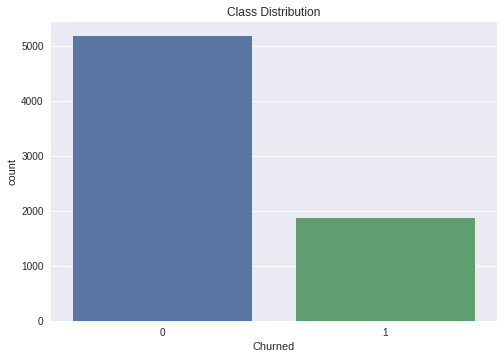

In [32]:
sns.countplot(x=df['Churned'])
plt.title('Class Distribution');

In [33]:
tmp = pd.DataFrame(df['Churned'].value_counts())
total = tmp['Churned'].sum()
tmp['%'] = round(100*tmp['Churned']/total)
tmp

,Churned,%
0,5174,73.0
1,1869,27.0


Our classes are unbalanced.  This will be addressed before we build our models.

## Relationship between features and churn

### Numeric features
Numeric features:
- `MonthlyCharges`
- `TotalCharges`
- `ServiceDays`
- `InternetServiceCount`
- `PhoneLineCount`

Since `MonthlyCharges` ≈ `[TotalCharges / ServiceDays] x 30`, we can focus on just 2 of these 3 features.

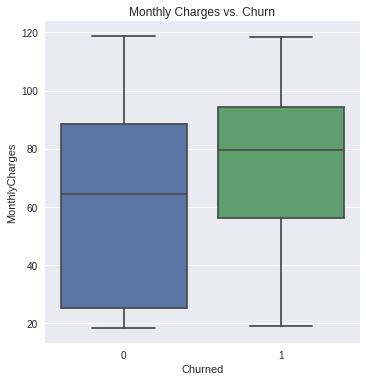

In [34]:
sns.catplot(x="Churned", y="MonthlyCharges", kind="box", data=df).set(title="Monthly Charges vs. Churn");

Customers who churned had higher monthly charges are more likely to churn.

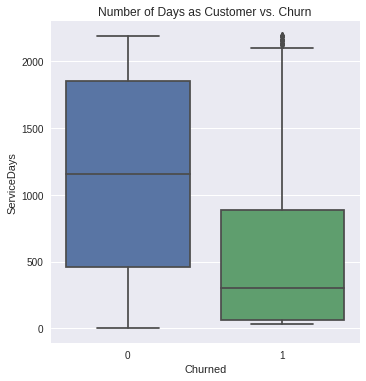

In [35]:
sns.catplot(x="Churned", y="ServiceDays", kind="box", data=df).set(title="Number of Days as Customer vs. Churn");

Customers who have had service for more than 1,000 days are *unlikely* to churn.

In [36]:
df.groupby('Churned')['ServiceDays'].mean()

Churned
0    1144.447236
1     547.352060
Name: ServiceDays, dtype: float64

Customers who churned did so at 547 days, on average.

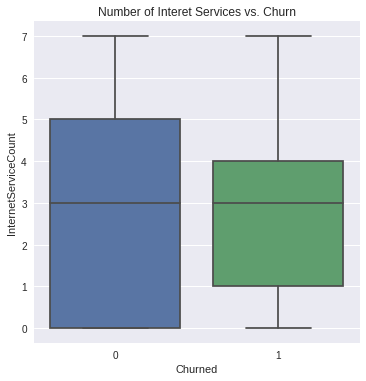

In [37]:
sns.catplot(x="Churned", y="InternetServiceCount", 
            kind="box", data=df).set(title="Number of Interet Services vs. Churn");

There is no clear relationship between the total number of internet services a customer uses and `Churn`.  (Although omitted for the sake of brevity, there was also no clear relationship between number of phone lines and `Churn`.)

### Categorical features
We will plot bar charts for each categorical feature.  Instead of using the raw numbers, we will scale both classes from 1 to 100 to facilitate comparison between the two targets.

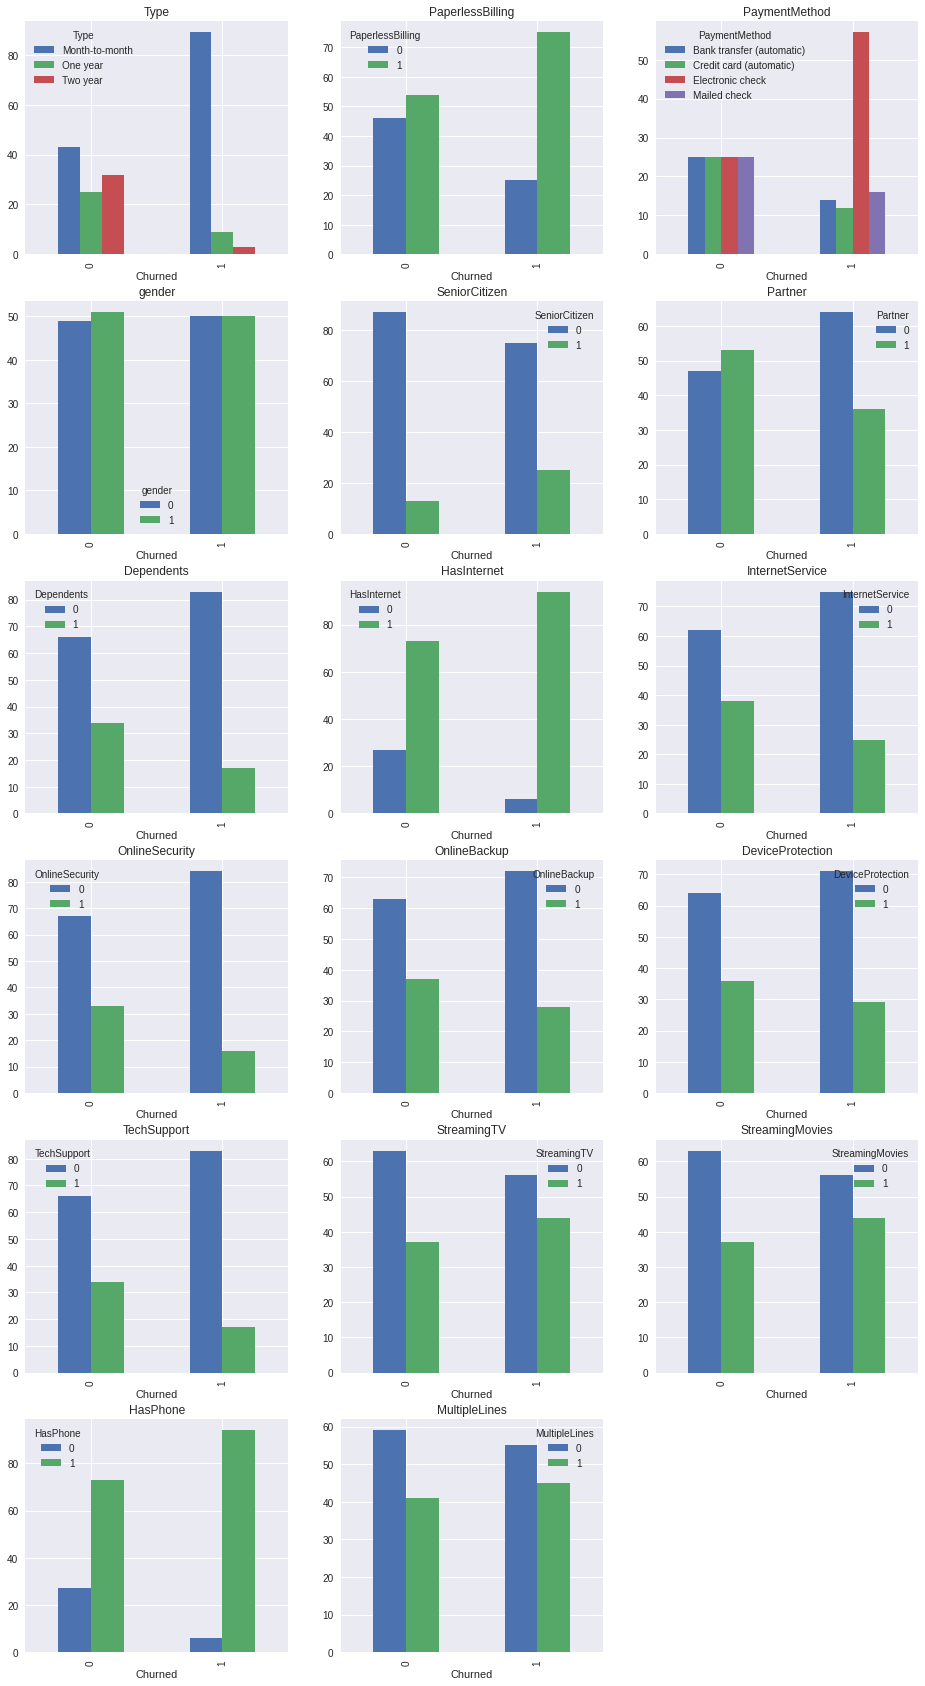

In [38]:
NUM_ROWS = 6
NUM_COLS = 3

fig, axs = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(16, 30))

exclude = ['Churned', 'MonthlyCharges', 'TotalCharges', 
          'ServiceDays', 'InternetServiceCount', 'PhoneLineCount']
categorical_features = [i for i in df.columns if i not in exclude]

for i in range(0, NUM_ROWS):
    for j in range(0, NUM_COLS):
        ndx = NUM_COLS*i+j
        if ndx > len(categorical_features)-1:
            break
        feature = categorical_features[ndx]
        axs[i, j].set_title(feature)
        
        # Create crosstab and rescale to 1-100, so that class imbalance
        # doesn't get in the way of visualization
        table = pd.crosstab(df['Churned'], df[feature])
        row_sum = [0, 0]
        for row in [0, 1]:
            for col in table.columns:
                row_sum[row] += table.loc[row, col]
        for row in [0, 1]:
            for col in table.columns:
                table.loc[row, col] = round(100 * table.loc[row, col]/row_sum[row])
        
        table.plot(kind='bar', ax=axs[i, j])
            
# Remove the last axis if there are more axces than parameters
fig.delaxes(axs[i, j])

plt.show()

The most important features are those that show very different distributions:
- `Type`:  Month-to-month is more likely to churn than 1- or 2-year contracts.
- `PaymentMethod`:  Checks (especially electronic) are more likely to churn than automatic payments.
- `InternetService`:  Fiber optic is more likely to churn.
- Internet add-on services:  Generally, customers who did not opt for add-on services are more likely to churn.  Of the many add-on services, online security and tech support have the biggest impact.
- Phone usage was about the same among customers who churned and those who didn't.

### Correlation

Let's look at the correlation between features and `Churned`.  To enable this for all features, we will perform a numeric encoding on categorical variables that have text labels.  (This *ad hoc* encoding is only for calculating correlation; one-hot encoding for modeling purposes will be performed later.)

In [39]:
def scale_contract_type(t):
    if t == 'Month-to-month':
        return 0
    if t == 'One year':
        return 0.5
    if t == 'Two year':
        return 1

df['TypeScaled'] = df['Type'].apply(scale_contract_type)

In [40]:
def scale_payment_method(m):
    if m == 'Credit card (automatic)':
        return 0
    if m == 'Bank transfer (automatic)':
        return 0.333
    if m == 'Mailed check':
        return 0.667
    if m == 'Electronic check':
        return 1

df['PaymentMethodScaled'] = df['PaymentMethod'].apply(scale_payment_method)

In [41]:
categorical_features.insert(0, 'Churned')
df_corr = pd.DataFrame(df.corr().iloc[:, 0])
df_corr['abs_tmp'] = abs(df_corr['Churned'])
pd.DataFrame(df_corr.sort_values(by='abs_tmp', ascending=False).iloc[:, 0])

,Churned
Churned,1.000000
TypeScaled,-0.396713
ServiceDays,-0.352673
PaymentMethodScaled,0.262783
HasInternet,0.227890
HasPhone,0.227890
TotalCharges,-0.198324
MonthlyCharges,0.193356
PaperlessBilling,0.191825
OnlineSecurity,-0.171226


The correlation results generally agree with our conclusions from the histograms:
- `Type`:  Customers with longer term contracts are less likely to churn.
- `ServiceDays`:  Customers who have had service for a long time are less likely to churn.
- `PaymentMethodOrd`:  Customers with automatic payment methods are less likely to churn.
- `MonthlyCharges`:  Customers with lower monthly charges as less likely to churn.

`HesInternet` and `HasPhone`, while high on the correlation list, are not useful predictors because they have the same correlation coefficient, and all customers have one or the other, or both.  `TotalCharges` is redundant because it can be closely approximated from `MonthlyCharges` and `ServiceDays`.

`PhoneLineCount` and `InternetServiceCount`, two features that we added during preprocessing, do not look very useful.

To speed up model development, we will remove several redundant or very poorly correlated features.  We will also drop the temporary columns that were created just for the correlation calculation.

In [42]:
df.drop(
    ['HasInternet', 'HasPhone', 'TotalCharges', 'PhoneLineCount', 'InternetServiceCount', 'gender',
    'TypeScaled', 'PaymentMethodScaled'], 
    axis=1,
    inplace=True)

## Conclusion (EDA)
Profile a customer likely to churn:
- Has higher-than-average monthly charges
- Has had service for less than 3 years
- Pays month-to-month
- Pays by mailed check
- Has fiberoptic internet service
- Did not opt for additional internet services, such as online security and tech support

# Model development
In this section, we wiil begin with additional preprcessing:  encoding categorical features, splitting the data into training and test sets, and addressing class imbalance.  Then we will develop the following tuned models:
- Dummy
- Logistic regression
- Decision tree
- Random forest
- Histogram gradient boosting
- Catboost
- Neural network

## Additional preprocessing

### Encode categorical features
Many of our features are already binary indicators.  We just have to encode the two that still have `object` type.

In [43]:
df = pd.get_dummies(df, columns=['Type', 'PaymentMethod'], drop_first=True)

### Split data into training and test sets

In [44]:
y = df['Churned']
X = df.drop('Churned', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RANDOM_STATE)

### Upsample to balance classes

In [45]:
y_train_majority = y_train[y_train == 0]
y_train_minority = y_train[y_train == 1]

X_train_majority = X_train[y_train == 0]
X_train_minority = X_train[y_train == 1]

len_majority = len(X_train_majority)

X_train_minority_upsampled = resample(X_train_minority, 
                                      replace=True,
                                      n_samples=len_majority,
                                      random_state=RANDOM_STATE)
X_train = pd.concat([X_train_majority, X_train_minority_upsampled])

y_train_minority_upsampled = resample(y_train_minority, 
                                      replace=True,
                                      n_samples=len_majority,
                                      random_state=RANDOM_STATE)
y_train = pd.concat([y_train_majority, y_train_minority_upsampled])

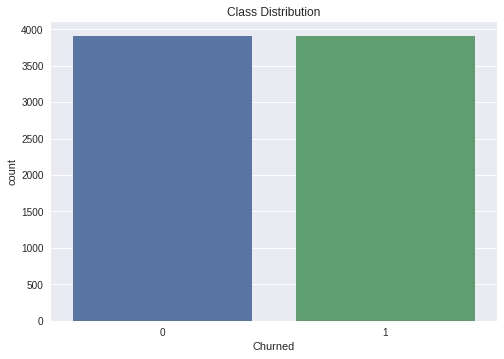

In [46]:
sns.countplot(x=y_train)
plt.title('Class Distribution');

### Scale numeric features

In [47]:
scaler = StandardScaler()
numeric_features = ['MonthlyCharges', 'ServiceDays']
scaler.fit(X_train[numeric_features])

X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

## Model evaluation function

In [48]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, 
                label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, 
                    marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, 
                    marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Dummy model

          train  test
Accuracy    0.5  0.72
F1          0.0  0.00
APS         0.5  0.28
ROC AUC     0.5  0.50


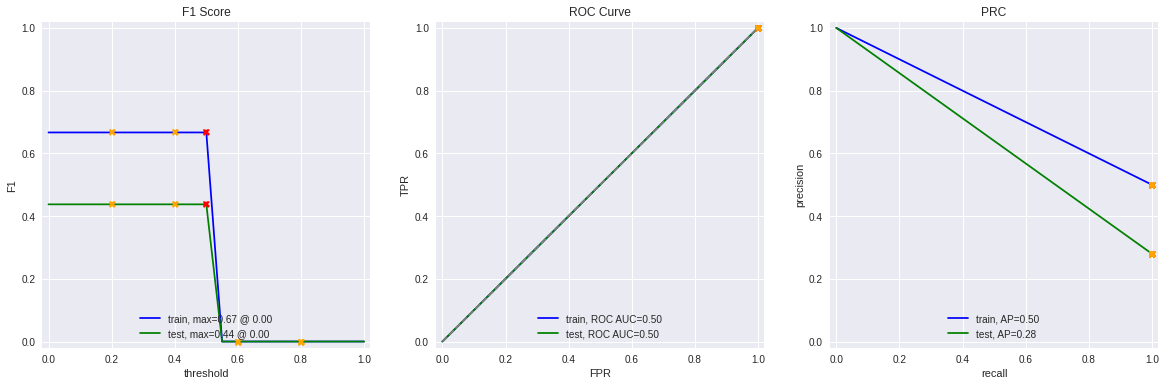

In [49]:
dummy = DummyClassifier()
dummy = dummy.fit(X_train, y_train)
evaluate_model(dummy, X_train, y_train, X_test, y_test)

## Logistic regression

In [50]:
best_logistic = None

if FINDING_HYPERPARAMETERS:
    logistic = LogisticRegression(random_state=RANDOM_STATE)
    param_grid = {'C': np.logspace(-3, 3, 20),
                  'solver': ['liblinear', 'lbfgs'],
                 }
    search = GridSearchCV(logistic, param_grid, scoring='roc_auc', 
                          random_state=RANDOM_STATE).fit(X_train, y_train)
    best_params = search.best_params_
else:
    best_params = { 'C': 0.0379269019073225, 'solver': 'liblinear'}

          train  test
Accuracy   0.76  0.75
F1         0.76  0.64
APS        0.82  0.66
ROC AUC    0.84  0.84


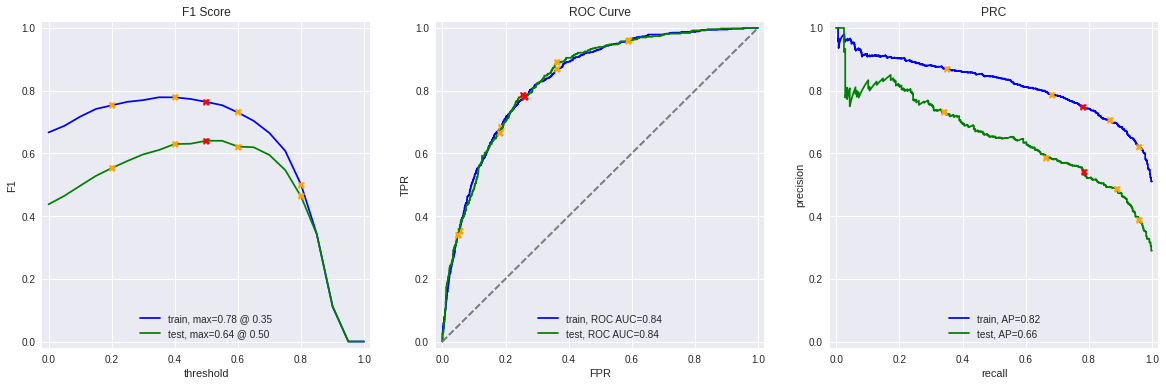

In [51]:
best_logistic = LogisticRegression(**best_params, random_state=RANDOM_STATE)
best_logistic.fit(X_train, y_train)
evaluate_model(best_logistic, X_train, y_train, X_test, y_test)

Logistic regression performed well with just one hyperparameter tuned and achieved an AUC of 0.84.

## Decision tree

In [52]:
best_tree = None

if FINDING_HYPERPARAMETERS:
    tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
    param_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': range(2, 12, 2),
                  'min_samples_leaf': range(2, 18, 2),
                  'min_samples_split': range(2, 26, 2)        
                 }
    search = GridSearchCV(tree, param_grid, scoring='neg_log_loss', 
                          random_state=RANDOM_STATE).fit(X_train, y_train)
    best_params = search.best_params_
else:
    best_params = {'criterion': 'entropy',
                   'max_depth': 8,
                   'min_samples_leaf': 8,
                   'min_samples_split': 24
                  }

          train  test
Accuracy   0.80  0.75
F1         0.80  0.63
APS        0.87  0.68
ROC AUC    0.89  0.84


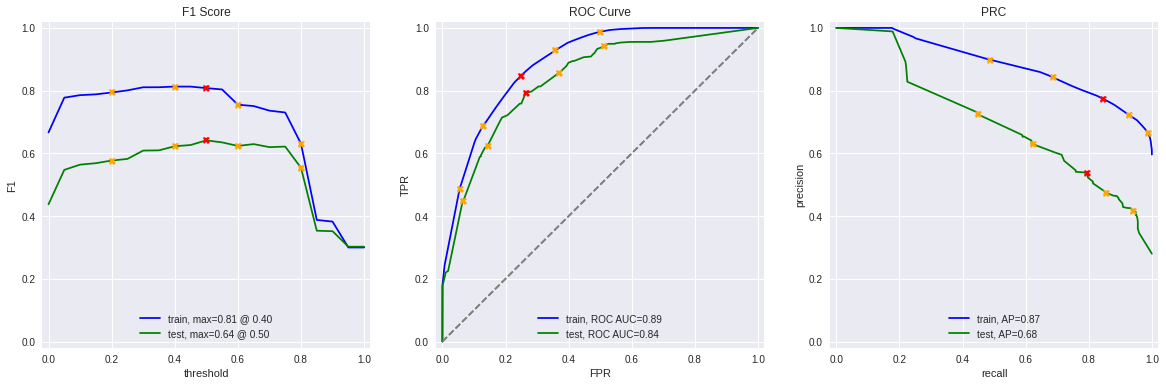

In [53]:
best_tree = DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE)
best_tree.fit(X_train, y_train)
evaluate_model(best_tree, X_train, y_train, X_test, y_test)

A simple decision tree performed about the same as logistic regression.

## Random forest

In [54]:
best_params = None

if FINDING_HYPERPARAMETERS:
    forest = RandomForestClassifier(random_state=RANDOM_STATE)

    param_grid = {'n_estimators': range(200, 650, 50),
                  'max_depth': range(9, 15),
                  'min_samples_leaf': range(1, 5),
                  'min_samples_split': range(2, 16, 2)
                 }
    search = HalvingGridSearchCV(forest, param_grid, scoring='roc_auc', min_resources='exhaust',
                                 random_state=RANDOM_STATE).fit(X_train, y_train)
    best_params = search.best_params_
else:
    best_params = {'max_depth': 12,
                   'min_samples_leaf': 1,
                   'min_samples_split': 4,
                   'n_estimators': 400
                  }

          train  test
Accuracy   0.94  0.79
F1         0.94  0.65
APS        0.98  0.71
ROC AUC    0.99  0.85


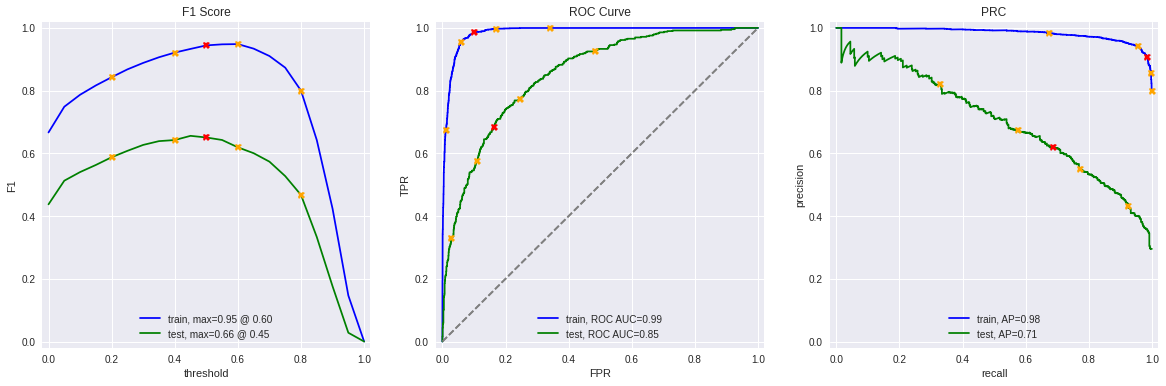

In [55]:
best_forest = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
best_forest.fit(X_train, y_train)
evaluate_model(best_forest, X_train, y_train, X_test, y_test)

Compared with logistic regression and a simple decision tree, we gain just 0.01 in AUC from a tuned random forest.

## Histogram gradient boosting

In [56]:
best_params = None

if FINDING_HYPERPARAMETERS:
    histgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

    param_grid = {'learning_rate' : [0.01, 0.025, 0.05, 0.075, 0.1],
                  'max_iter' : range(900, 1350, 50),
                  'max_depth' : range(9, 15),
                  'min_samples_leaf' : range(1, 5),
                  'scoring' : ['roc_auc']
                 }
    search = HalvingGridSearchCV(histgb, param_grid, scoring='roc_auc', min_resources='exhaust',
                                 random_state=RANDOM_STATE).fit(X_train, y_train)
    best_params = search.best_params_
else:
    best_params = {'learning_rate': 0.05,
                   'max_depth': 12,
                   'max_iter': 1100,
                   'min_samples_leaf': 3,
                   'scoring': 'roc_auc'
                  }

          train  test
Accuracy    1.0  0.86
F1          1.0  0.75
APS         1.0  0.84
ROC AUC     1.0  0.91


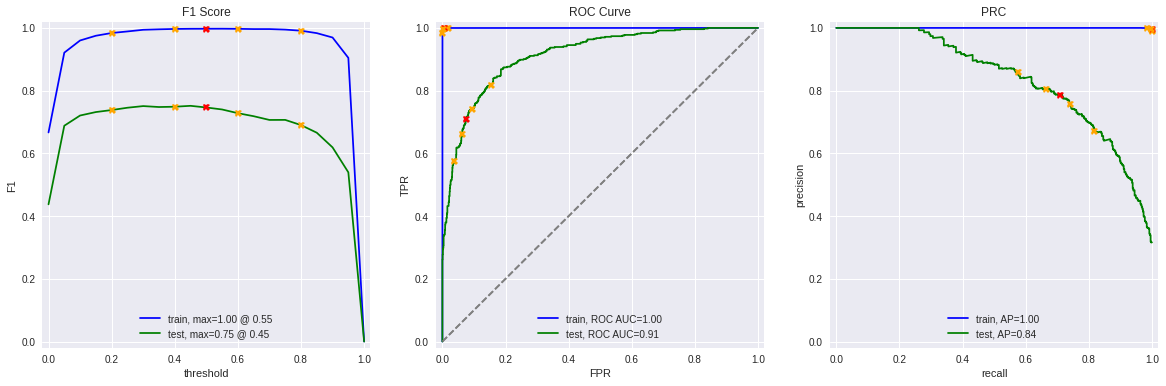

In [57]:
best_histgb = HistGradientBoostingClassifier(**best_params, random_state=RANDOM_STATE)
best_histgb.fit(X_train, y_train)
evaluate_model(best_histgb, X_train, y_train, X_test, y_test)

Histogram gradient boosting performed better than previous models, with an AUC of 0.91.

## Catboost

          train  test
Accuracy   0.93  0.84
F1         0.93  0.74
APS        0.98  0.83
ROC AUC    0.98  0.91


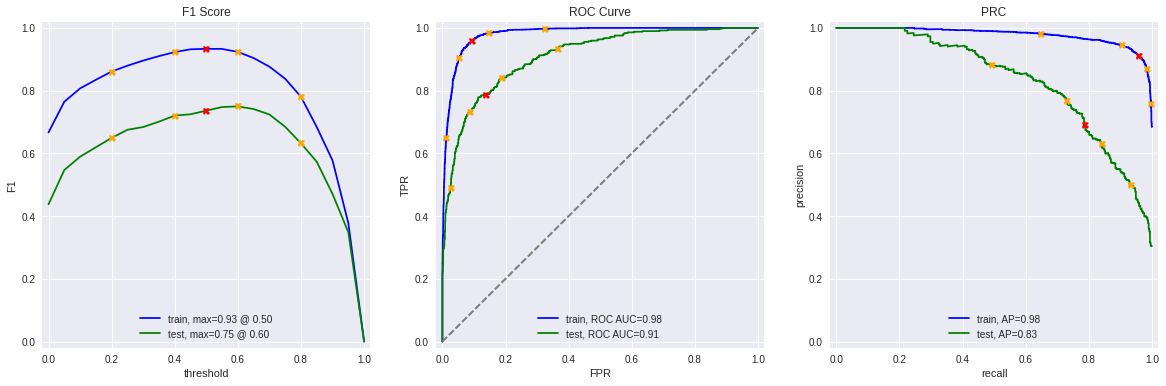

In [58]:
cat = CatBoostClassifier(verbose=False)
cat.fit(X_train, y_train)
evaluate_model(cat, X_train, y_train, X_test, y_test)

A Catboost model with only the default parameters performed as well the tuned histogram gradient boosting model.  Catboost achieved an AUC of 0.91.  This was the simplest model to create, and it achieved a good score.  Catboost defied my efforts at hyperparameter tuning.  I tried adjusting the number of trees and depth, and I tried a grid search with several parameters, but these tuning efforts never achieved an AUC score greater than the default model.

### Feature importance

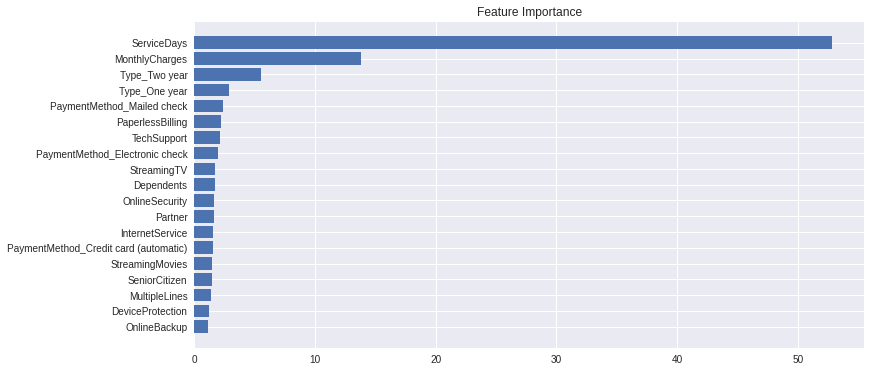

In [59]:
feature_importance = cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

As noted in the EDA section, customers are most likely to churn in the first 1-2 years.  High monthly charges, shorter contracts, and paying by mailed check are key drivers of churn.

## Neural network
I will take a different approach for the neural network model than with previous models.  I will show the relationships between various parameters and a default model.  Then, I will attempt to improve the baseline model by incorporating the best individual parameters.  Finally, I will fine-tune one or two parameters to arrive at the final model.

Steps:

1.  Build and evaluate a baseline model.
2.  Evaluate the effects of various parameters:  Adjust one parameter at a time while keeping other parameters at baseline values.  Create plots showing the importance of each parameter and the effect of each parameter on classification metrics.
3.  Use the best parameters from the previous step to define and evaluate a new baseline model.
4.  Starting from the new baseline model, fine-tune the most important parameter or parameters.
5.  Build and evaluate the final model.

### Constants and helper functions

In [60]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress unwanted Keras/GPU messages

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

In [61]:
# Baseline parameters and constants
ACTIVATION     = 'relu'
ACTIVATION_OUT = 'sigmoid'
BATCH_SIZE     = 8
CV             = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
DROPOUT_RATE   = 0.2
EPOCHS         = 10
INITIALIZER    = 'random_uniform'
INPUT_DIM      = X_train.shape[1]
LEARNING_RATE  = 0.001
LOSS           = 'binary_crossentropy'
METRICS        = 'accuracy' # AUC fails to generate CV scores
NUM_LAYERS     = 1
NUM_UNITS      = 10
OPTIMIZER      = 'Adam'
VERBOSE        = False

In [62]:
#
# Builds a fully connected network with specified parameters
#
def build_model(activation=ACTIVATION,
                activation_out=ACTIVATION_OUT,
                dropout_rate=DROPOUT_RATE,
                initializer=INITIALIZER,
                input_dim=INPUT_DIM,
                learning_rate=LEARNING_RATE,
                loss=LOSS,
                metrics=METRICS,
                num_layers=NUM_LAYERS,
                num_units=NUM_UNITS,
                optimizer=OPTIMIZER
               ):
    model = Sequential()
    
    # A dropout layer will be included after each hidden layer.
    model.add(Dropout(dropout_rate, input_shape=(INPUT_DIM,)))
    
    # Input and first hidden layer
    model.add(Dense(units=num_units, 
                    #input_dim=input_dim,
                    kernel_initializer=initializer,
                    activation=activation)
             )
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for i in range(0, num_layers):
        model.add(Dense(units=num_units,
                        kernel_initializer=initializer,
                        activation=activation)
                 )
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(units=1,
                    kernel_initializer=initializer,
                    activation=activation_out)
             )            
    optimizer_class = getattr(importlib.import_module("tensorflow.keras.optimizers"), optimizer)
    optimizer = optimizer_class(lr=learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
    
    return model

In [63]:
#
# Gets cross-validation scores for a set of tuning parameters
#
def tune_params(tuning_options):
    search_results = {}

    for parameter, options in tuning_options.items():
        print(f'{parameter}:')
        search_results[parameter] = {}
        search_results[parameter]['options'] = options
    
        scores = []
        model = KerasClassifier(build_fn=build_model, verbose=VERBOSE)
    
        for option in options:
            # Set classifer with tuning option
            clf_params = {}
            clf_params[parameter] = option
            model.set_params(**clf_params)
        
            # Cross validate and save the average score
            score = cross_val_score(model, X_train, y_train, cv=CV).mean()
            scores.append(score)
            print(f'    {option} ==> {score:{1}.{4}}')
    
        # Add CV scores to search results
        search_results[parameter]['scores'] = scores
    
    return search_results

In [64]:
#
# Transforms search results into a dataframe for plotting
#
def wrangle_results(search_results):
    search_results_tmp = deepcopy(search_results)
    results_df = pd.DataFrame()

    for param_name in search_results_tmp.keys():
        param_result = search_results_tmp[param_name]
        param_result['parameter'] = [param_name]*len(param_result['scores'])
        results_df = pd.concat([results_df, pd.DataFrame(param_result)])
    
    return results_df

In [65]:
#
# Plots the distribution of scores for each parameter
#
def plot_dist(results_df):
    sns.set(rc={"figure.figsize":(16, 5)})
    sns.boxplot(x='parameter', y='scores', data=results_df).set_title('Accuracy Ranges by Parameter')

In [66]:
#
# Plots the scores for each parameter
#
def plot_trend(df): 
    fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(16, 16))
    axes = axes.flatten()

    params = df.parameter.unique().tolist()

    for i, ax in enumerate(axes):
        try:
            # Each subplot corresponds to one parameter
            param = params[i]
            df_param = df.query("parameter==@param")
            df_param.plot(kind='line', x='options', y='scores', ax=ax)

            # Log-transform the x-axis for learning rate to avoid mixing up
            if param == 'learning_rate':
                ax.set_xscale('log')
            
            # Make smaller labels for initializer names
            if param == 'initializer':
                ax.set_xticks(np.arange(len(df_param)))
                ax.set_xticklabels(['rnd_uni', 'he_nml', 'gr_nml', 'var_scal', 'trunc_nml'])

            ax.set_xlabel(param, fontsize=16) 
            ax.set_ylabel('Accuracy', fontsize=16) 
            ax.get_legend().remove()
        except Exception as e: 
            # Remove the last axis if there are more axces than parameters
            fig.delaxes(ax)
  
    fig_title = 'Parameter Tuning Trends'
    fig.suptitle(fig_title, y=0.92, verticalalignment='bottom', fontsize=30)
  
    plt.show()

### Baseline model

          train  test
Accuracy   0.77  0.74
F1         0.77  0.64
APS        0.83  0.66
ROC AUC    0.84  0.84


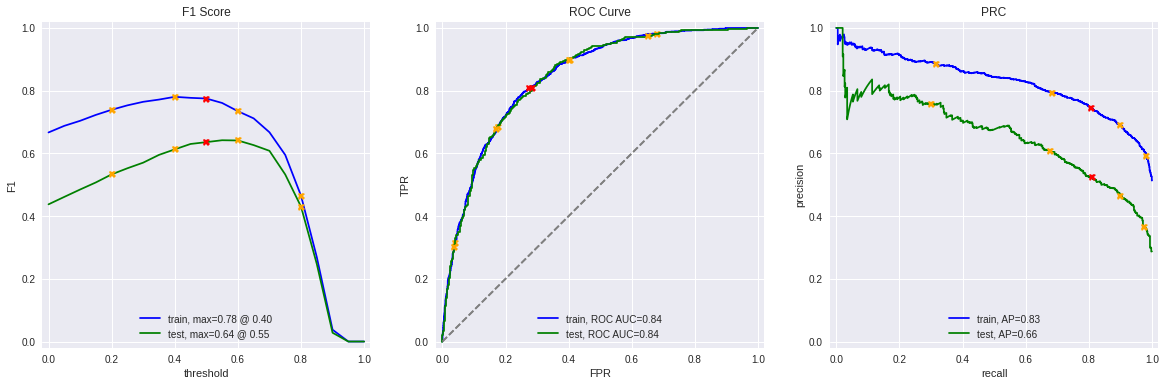

In [67]:
model = KerasClassifier(build_fn=build_model, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE)
model.fit(X_train, y_train)
evaluate_model(model, X_train, y_train, X_test, y_test)

### Effects of tuning parameters

In [68]:
tuning_options = {'num_units': [4, 8, 16, 32, 64],
                  'num_layers': [0, 1, 2, 4, 8],
                  'initializer': ['random_uniform', 'he_normal', 'glorot_normal', 
                                  'variance_scaling', 'truncated_normal'],
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
                  'optimizer': ['Adam', 'Nadam', 'Adagrad', 'SGD', 'RMSprop'],                  
                  'epochs': [5, 10, 20, 40, 80],
                  'batch_size': [2, 4, 8, 16, 32],
                  'activation': ['relu', 'softmax', 'sigmoid', 'softsign', 'tanh'],
                  'dropout_rate': [0.0, 0.2, 0.4, 0.6, 0.8]
                 }

In [69]:
search_results = tune_params(tuning_options)

num_units:
    4 ==> 0.6607
    8 ==> 0.7582
    16 ==> 0.7526
    32 ==> 0.7558
    64 ==> 0.7584
num_layers:
    0 ==> 0.7559
    1 ==> 0.754
    2 ==> 0.7591
    4 ==> 0.5
    8 ==> 0.5001
initializer:
    random_uniform ==> 0.7563
    he_normal ==> 0.6966
    glorot_normal ==> 0.7354
    variance_scaling ==> 0.7346
    truncated_normal ==> 0.754
learning_rate:
    0.0001 ==> 0.7089
    0.001 ==> 0.7577
    0.01 ==> 0.7563
    0.1 ==> 0.717
    1 ==> 0.5001
optimizer:
    Adam ==> 0.7504
    Nadam ==> 0.7549
    Adagrad ==> 0.5201
    SGD ==> 0.5398
    RMSprop ==> 0.7541
epochs:
    5 ==> 0.7586
    10 ==> 0.7646
    20 ==> 0.7605
    40 ==> 0.7609
    80 ==> 0.7643
batch_size:
    2 ==> 0.7522
    4 ==> 0.7577
    8 ==> 0.7588
    16 ==> 0.7556
    32 ==> 0.754
activation:
    relu ==> 0.7549
    softmax ==> 0.5
    sigmoid ==> 0.5141
    softsign ==> 0.756
    tanh ==> 0.7541
dropout_rate:
    0.0 ==> 0.7549
    0.2 ==> 0.7514
    0.4 ==> 0.7551
    0.6 ==> 0.7428
    0.8 ==> 0.5

In [70]:
results_df = wrangle_results(search_results)
#results_df

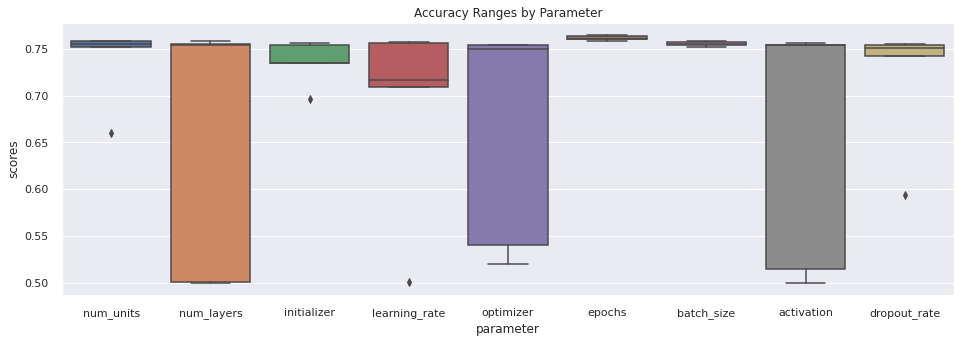

In [71]:
plot_dist(results_df)

The choices for number of layers, optimizer, and activation make the biggest difference in scores.

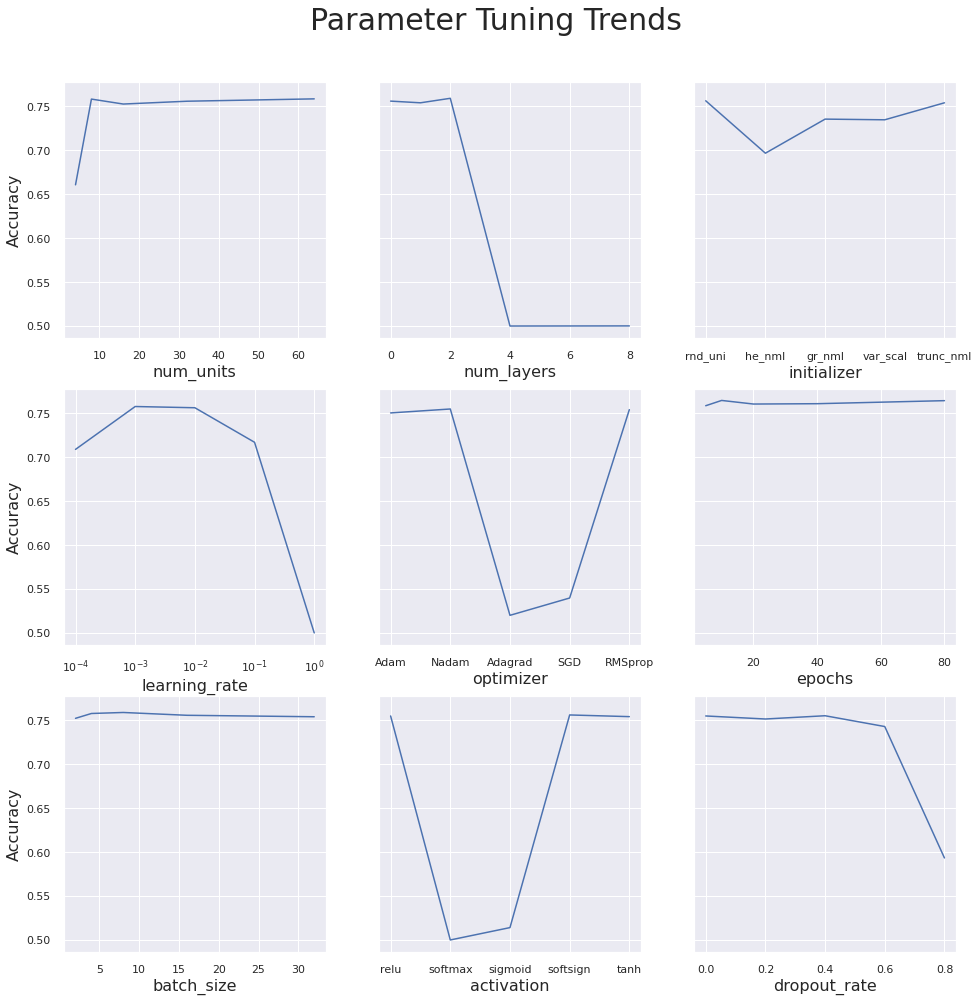

In [72]:
plot_trend(results_df)

- `num_units`:  The number of neurons in in each layer reaches a plateau around 10, which is about half of the number of input features.  Our default is already 10, so there is little room for improvement.
- `num_layers`:  The number of the hidden layers between the first one and the output layer is about the same for 0, 1, or 2 "extra" hidden layers.  Performance decreases if more than 2 extra layers are added.  Our default choice of 1 was good.
- `initializer`:  Our default choice of `random_uniform` performed well.
- `optimizer`: Our default choice of `Adam` performed well.
- `epochs`:  Surprisingly, the number of epochs did not affect model performance.
- `batch_size`:  Also surprisingly, the batch size did not affect model performance.
- `activation`:  Our default choice of `relu` performed well.  In the next phase, we will try `tanh`, but any improvement is expected to be very small.
- `dropout_rate`:  Dropout does not affect model performance unless a large proportion of observations is dropped.

In the next section, we will make a few "tweaks" based on these findings, but because our baseline parameters were good, little improvement can be expected.

### New baseline model

In [73]:
NUM_UNITS      = 16               # Increased from 10
NUM_LAYERS     = 1                # Unchanged
INITIALIZER    = 'random_uniform' # Unchanged
OPTIMIZER      = 'Adam'           # Unchanged
EPOCHS         = 10               # Unchanged
BATCH_SIZE     = 32               # Increased from 8
ACTIVATION     = 'tanh'           # Changed from 'relu'
DROPOUT        = 0.4              # Increased from 0.2
LEARNING_RATE  = 0.001            # Unchanged for now, will fine tune in next step

          train  test
Accuracy   0.76  0.76
F1         0.77  0.65
APS        0.83  0.66
ROC AUC    0.84  0.84


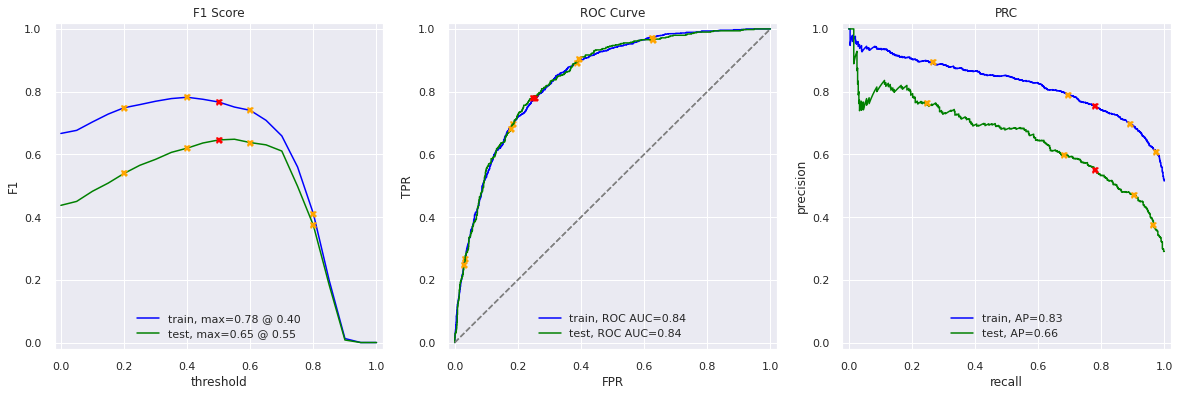

In [74]:
model = KerasClassifier(build_fn=build_model, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE)
model.fit(X_train, y_train)
evaluate_model(model, X_train, y_train, X_test, y_test)

### Fine tuning of learning rate

In [75]:
learning_rates = np.logspace(-3.0, -1.0, num=20)
learning_rates

array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
       0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
       0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
       0.0379269 , 0.0483293 , 0.06158482, 0.078476  , 0.1       ])

In [76]:
tuning_options = {'learning_rate': list(learning_rates)}
search_results = tune_params(tuning_options)

learning_rate:
    0.001 ==> 0.7545
    0.0012742749857031334 ==> 0.7572
    0.001623776739188721 ==> 0.7545
    0.00206913808111479 ==> 0.754
    0.0026366508987303583 ==> 0.754
    0.003359818286283781 ==> 0.7545
    0.004281332398719396 ==> 0.7577
    0.00545559478116852 ==> 0.7595
    0.0069519279617756054 ==> 0.7573
    0.008858667904100823 ==> 0.754
    0.011288378916846888 ==> 0.7596
    0.01438449888287663 ==> 0.7579
    0.018329807108324356 ==> 0.7519
    0.023357214690901212 ==> 0.7552
    0.029763514416313176 ==> 0.7527
    0.0379269019073225 ==> 0.7561
    0.04832930238571752 ==> 0.7567
    0.06158482110660261 ==> 0.7467
    0.07847599703514611 ==> 0.7303
    0.1 ==> 0.7424


In [77]:
results_df = wrangle_results(search_results)
best_result = results_df.query('scores == scores.max()')
best_result

,options,scores,parameter
10,0.011288,0.759599,learning_rate


### Final model

In [78]:
LEARNING_RATE = best_result.index.values[0]

          train  test
Accuracy   0.76  0.76
F1         0.76  0.65
APS        0.83  0.66
ROC AUC    0.84  0.84


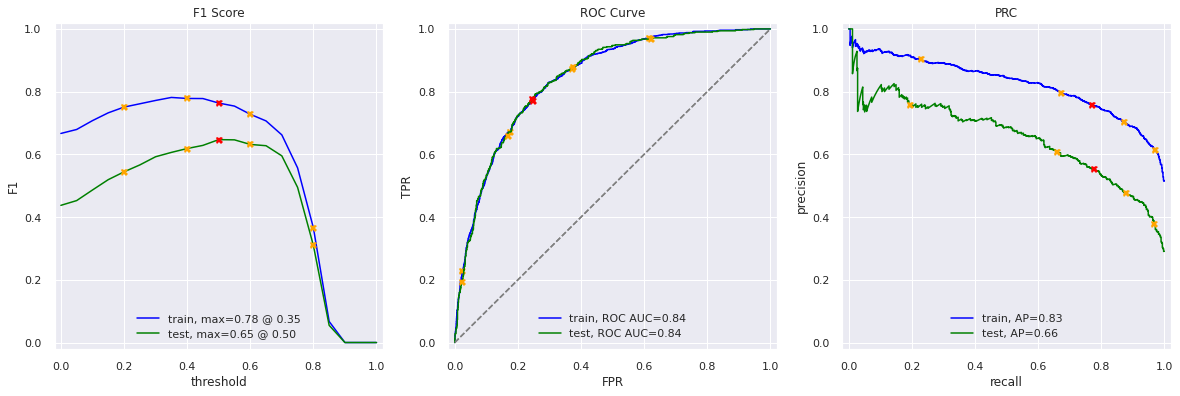

In [79]:
model = KerasClassifier(build_fn=build_model, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE)
model.fit(X_train, y_train)
evaluate_model(model, X_train, y_train, X_test, y_test)

Even with careful tuning, the neural network did not perform as well as histogram gradient boosting or Catboost.  The  baseline parameters created a reasonably good model, and the improvements from tuning were negligible (seen only when looking the 3rd or 4th decimal places of evaluation metrics.)

## Conclusion (model development)

In [80]:
pd.DataFrame({
    'Model':['Dummy', 'Logistic regression', 'Decision tree', 'Random forest', 
            'Histogram GB', 'Catboost', 'Neural network'],
    'AUC-ROC':[0.5, 0.84, 0.84, 0.85, 0.91, 0.91, 0.84]
}).set_index('Model').sort_values(by='AUC-ROC', ascending=False)

,AUC-ROC
Model,
Histogram GB,0.91
Catboost,0.91
Random forest,0.85
Logistic regression,0.84
Decision tree,0.84
Neural network,0.84
Dummy,0.50


Histogram gradient boosting and Catboost were the best performers, with AUC scores of 0.91.

# Conclusion
Interconnect can use a machine learning model such as Catboost to identify customers who are at risk to churn.  Our exploratory data analysis, as well the feature importance scores from the Catboost model, show why customers churn.  Customers are most likely to churn within the first 1-2 years of service, especially if they have high montly charges, short-term contracts, and if they use non-automated payment methods.  To address this, Interconnect can develop retention programs for customers likely to churn.  For example, they can offer discounts to newer customers if the customer agrees to a longer-term contract or automatic payment.